# Churn Prediction Model on Amazon dataset

## Dataset Exploration And Preparation

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [125]:
df = pd.read_csv('/content/Amazon.csv')

In [126]:
df.shape

(4883, 14)

In [127]:
df.isnull().sum()

,0
product_id,0
product_name,0
Major Category,0
Sub Category,0
discounted_price,0
actual_price,0
discount_percentage,0
user_id,0
user_name,0
review_id,0


In [128]:
#dropping null rating count, review content, review title rows
df = df.dropna(subset=['rating_count','review_content', 'review_title'])
df.isnull().sum()

,0
product_id,0
product_name,0
Major Category,0
Sub Category,0
discounted_price,0
actual_price,0
discount_percentage,0
user_id,0
user_name,0
review_id,0


In [129]:
df.shape

(4777, 14)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4777 entries, 0 to 4882
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           4777 non-null   object
 1   product_name         4777 non-null   object
 2   Major Category       4777 non-null   object
 3   Sub Category         4777 non-null   object
 4   discounted_price     4777 non-null   object
 5   actual_price         4777 non-null   object
 6   discount_percentage  4777 non-null   object
 7   user_id              4777 non-null   object
 8   user_name            4777 non-null   object
 9   review_id            4777 non-null   object
 10  review_title         4777 non-null   object
 11  review_content       4777 non-null   object
 12  rating               4777 non-null   object
 13  rating_count         4777 non-null   object
dtypes: object(14)
memory usage: 559.8+ KB


In [131]:
df['Major Category'].value_counts()

,count
Major Category,
Electronics,1704
Home&Kitchen,1559
Computers&Accessories,1372
OfficeProducts,112
MusicalInstruments,10
HomeImprovement,10
Toys&Games,5
Health&PersonalCare,3
Car&Motorbike,2


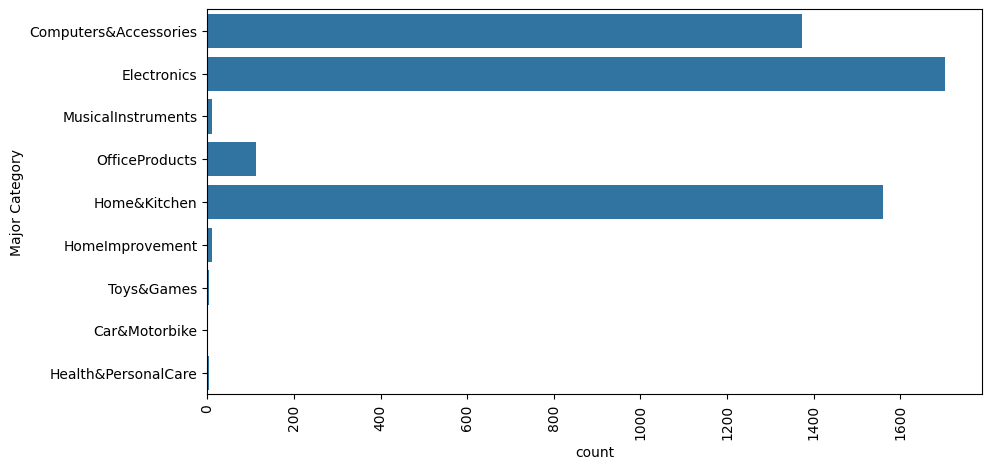

In [132]:
plt.figure(figsize=(10,5))
sns.countplot(df['Major Category'])
plt.xticks(rotation=90)
plt.show()

In [133]:
df['review_content'].sample(5).iloc[0]

'within 1 day they delivered me new one without any cost.Great product  good service.'

## Text Preprocessing

## Cleaning Data
- Removing URLs,
- Removing hashtags,
- Removing special letters,
- Removing punctuations
- Removing emoji
- Removing stop words
- Lemmatization

In [134]:
df.head(1)

,product_id,product_name,Major Category,Sub Category,discounted_price,actual_price,discount_percentage,user_id,user_name,review_id,review_title,review_content,rating,rating_count
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,USBCables,₹399,"₹1,099",64%,AHMY5CWJMMK5BJRBBSNLYT3ONILA,Adarsh gupta,R3HXWT0LRP0NMF,Charging is really fast,Charging is really fast,4.2,"24,269"


In [135]:
# FEATURE EXTRACTION
df["review_text"] = df["review_title"] + " " + df["review_content"]

In [136]:
df.drop(['review_title', 'review_content'], axis=1, inplace=True)

In [137]:
!pip install emoji

In [138]:
# CLEANING DATA
import re
import emoji

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.lower()

    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['review_text'] = df['review_text'].apply(clean_text)

In [139]:
# LEMMATIZATION
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

df['review_text'] = df['review_text'].apply(
    lambda x: ' '.join(lemmatizer.lemmatize(word) for word in str(x).split())
)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [140]:
df['review_text'].sample(5).values.tolist()

['dont buy this good',
 'best 4g phone for around 10 500rs it can even beat smartphones upto 15',
 'noise the mode in the watch are good the ui suck responsiveness could have been better battery life is moderately upto 34 day if worn constantly colour of the band is a bit faded too',
 'good overall good',
 'very good']

### Sentiment Analysis- Churn Label

In [141]:
!pip install vaderSentiment

In [142]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['review_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [143]:
def label_churn(score):
    if score <= -0.5:
      #churned
      return 1
    else:
      #not churned
      return 0

neg_df = df[df['sentiment_score'] < -0.05].copy()

In [144]:
df.sample(5)

,product_id,product_name,Major Category,Sub Category,discounted_price,actual_price,discount_percentage,user_id,user_name,review_id,rating,rating_count,review_text,sentiment_score
3428,B0814P4L98,PrettyKrafts Laundry Basket for clothes with L...,Home&Kitchen,LaundryBaskets,₹351,₹999,65%,AEATZAGPDVY63OECCENTN5XZHNNQ,Shruti Didhate,R13P4JW3JTQ20L,4,"5,380",very useful very useful,0.7684
3135,B00NFD0ETQ,Logitech G402 Hyperion Fury USB Wired Gaming M...,Computers&Accessories,GamingMice,"₹1,995","₹2,895",31%,AGFIU57KQ27B2HIIHLNRXEX4LD3A,parin patel,R2W6BKEVXNT3N,4.6,"10,760",good mouse good mouse overall price is little ...,0.7003
3381,B097R2V1W8,Bajaj Splendora 3 Litre 3KW IWH Instant Water ...,Home&Kitchen,InstantWaterHeaters,"₹2,599","₹5,890",56%,AEZPAJHK366QB5JCBQNS26MJHZKQ,Pushp Raj,R3C9QHHIKL25X,4.1,"21,783",tiny bomb very nice and working well taking 23...,0.2484
3804,B0B4PPD89B,Kitchenwell 18Pc Plastic Food Snack Bag Pouch ...,Home&Kitchen,VacuumSealers,₹79,₹79,0%,AFEQ7NC66N46VGPPVC2NXFWRCW7A,RDP,R2YLDT44YPDA2G,4,97,value for money second quality,0.3400
3421,B00YMJ0OI8,Prestige PIC 20 1600 Watt Induction Cooktop wi...,Home&Kitchen,InductionCooktop,"₹2,148","₹3,645",41%,AFY52SCGUVXVGOTEYS4SI2DNI6LA,Saravana r.,R14ACX2RTXLHYX,4.1,"31,388",nice easytouse,0.4215


## Text Vectorization

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf.fit(neg_df['review_text'])
required_text  = tfidf.transform(neg_df['review_text'])

In [146]:
required_text

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5208 stored elements and shape (503, 1865)>

In [147]:
neg_df.sample(1)

,product_id,product_name,Major Category,Sub Category,discounted_price,actual_price,discount_percentage,user_id,user_name,review_id,rating,rating_count,review_text,sentiment_score
412,B099K9ZX65,Hisense 108 cm (43 inches) 4K Ultra HD Smart C...,Electronics,SmartTelevisions,"₹20,990","₹44,990",53%,AHFQGP45QKIEFKYOCYUH4DP63XGQ,Gautam Jethwa,R1Z33CAT0B5EQM,4.1,"1,259",good size for small leaving room of 1896 redmi...,-0.6772


## Forming Clusters

In [148]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)  # Try different k
neg_df['cluster'] = kmeans.fit_predict(required_text)

In [149]:
print(neg_df['cluster'].value_counts())

cluster
0    348
1    113
2     42
Name: count, dtype: int64


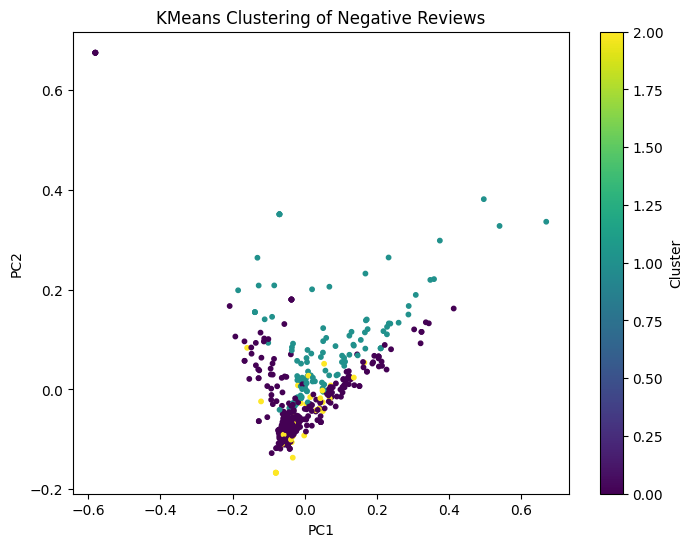

In [150]:
from sklearn.decomposition import PCA
# Reduce to 2D
X_reduced = PCA(n_components=2).fit_transform(required_text.toarray())

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=neg_df['cluster'], cmap='viridis', s=10)
plt.title("KMeans Clustering of Negative Reviews")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

## Train Test Split

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(required_text, neg_df['cluster'], test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(knn.score(X_test, y_test))

0.7821782178217822


## Cluster Values

In [152]:
import numpy as np

def get_top_keywords(kmeans_model, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    for i, center in enumerate(kmeans_model.cluster_centers_):
        print(f"\nCluster {i} top words:")
        top_indices = center.argsort()[-n_terms:][::-1]
        print(", ".join([terms[idx] for idx in top_indices]))

get_top_keywords(kmeans, tfidf)


Cluster 0 top words:
good, quality, working, wa, just, cable, use, bad, like, got

Cluster 1 top words:
product, good, bad, quality, wa, buy, worst, poor, average, working

Cluster 2 top words:
charging, sturdy, doe, support, cable, 33w, product, fast, good, working
